In [1]:
from decimal import Decimal
import numpy as np 
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext,Executor
from typing import Dict, List, Tuple
from dataclasses import dataclass
from cadCAD.configuration.utils import env_trigger, bound_norm_random, ep_time_step, config_sim
import pandas as pd


# Overview 

Simple example of a cadCAD model components. 

1. Using data classes as our struct.
2. Policy function - mechanism behavior at each step (block).
3. state update function - changes the state based on the policy.
4. Partial state update blocks - define the order that policies and state updates are run.


### Data Classes

In [2]:
@dataclass
class pool: 
    pool_asset_depth: float
    pool_rune_depth: float
    pool_asset_collateral: float
    pool_rune_collateral: float
    pool_yield: float # percent
    asset_price_usd: float

### Policy

In [3]:
# behavior, logic
def btc_pool_policy(params, step, history, current_state): 
    
    """
    simple example Policy to increase yield by 1% each block.
    """
    
    btc_pool = current_state['btc_pool']
    
    current_yield = btc_pool.pool_yield 
    
    new_yield = current_yield + 1.0
    
    
    return {'update_pool_yield' : new_yield}

### State update

In [4]:
# mechanism
def su_btc_pool(params, step, sL, s, _input):
    
    # get current timestap
    if s['timestep'] > 0:
        current_timestep = s['timestep'] + 1
    else: 
        current_timestep = 0
    
    btc_pool = s['btc_pool']
    btc_pool.pool_yield = _input['update_pool_yield']
    btc_pool.asset_price_usd = params['btc_price']['btc_price'][current_timestep]
    
    return ('btc_pool', btc_pool)

### Config PSUB

In [5]:
config_partial_state_update_blocks = [
    {
        'policies': {
            'btc_pool_policy': btc_pool_policy,
        },
        # keys for State Update funcs
        'variables': {
            'btc_pool' : su_btc_pool, # state of the pool
    }
    },
]

### Define Initial state

In [6]:
# btc LP pool values
btc_pool = pool(pool_asset_depth=875.0,
                #asset = 'BTC.BTC',
                pool_rune_depth=5000000,
                pool_asset_collateral = 175.0, 
                pool_rune_collateral=1000000,
                pool_yield=20.0, # percent
                asset_price_usd=40000.0,
               )


INITIAL_STATE_DICT = {
    'btc_pool' : btc_pool, # state of the pool    
}


### Sys params

In [7]:
btc_price_df = pd.DataFrame({'btc_price': [40000.0, 39000.0, 35000.0, 60000.0]})

In [9]:
btc_price_df


btc_price
0    40000.0
1    39000.0
2    35000.0
3    60000.0

In [8]:
sys_params = {
    
    'btc_price': [btc_price_df]
}

### Sim config

In [12]:
sim_config = config_sim({
    'T': range(3), # number of discrete iterations in each experiment
    'N': 1, # number of times the simulation will be run (monte carlo runs)
    'M': sys_params,# g # param sweep dict
})

### Instantiate Model

In [13]:

exp = Experiment()
exp.append_model(
    model_id = 'basic-btc-pool', # OPTIONAL: System Model label
    initial_state = INITIAL_STATE_DICT, # System Model
    partial_state_update_blocks = config_partial_state_update_blocks, # System Model
    policy_ops =[btc_pool_policy], # System Model
    sim_configs = sim_config, # Simulation Properties
    # user_id = ..., # OPTIONAL: Configuration User ID
)

### Execute model

In [14]:
exec_mode = ExecutionMode()
local_proc_ctx = ExecutionContext(context=exec_mode.local_mode)
run = Executor(exec_context=local_proc_ctx, configs=exp.configs)

raw_result, tensor_field, sessions = run.execute()
result = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 3, 1, 1, 1)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (3, 1, 1, 1)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.01s


In [15]:
result

btc_pool  simulation  subset  run  \
0  pool(pool_asset_depth=875.0, pool_rune_depth=5...           0       0    1   
1  pool(pool_asset_depth=875.0, pool_rune_depth=5...           0       0    1   
2  pool(pool_asset_depth=875.0, pool_rune_depth=5...           0       0    1   
3  pool(pool_asset_depth=875.0, pool_rune_depth=5...           0       0    1   

   substep  timestep  
0        0         0  
1        1         1  
2        1         2  
3        1         3

In [16]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Asset Price, USD')

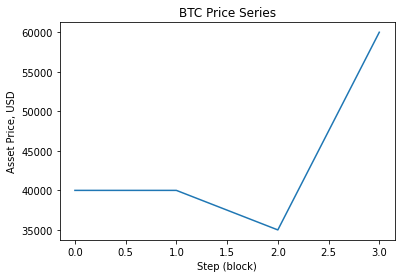

In [17]:
price_series = []

for step in result['btc_pool']:
    
    price_series.append(step.asset_price_usd)
    


plt.title('BTC Price Series')
plt.plot(price_series)
plt.xlabel('Step (block)')
plt.ylabel('Asset Price, USD')

### In the results we can see the pool_yield increases each step.

ok that's boring - what next? 

Build out the policies and state update functions for ThorFi.

In [15]:
raw_result

[{'btc_pool': pool(pool_asset_depth=875.0, pool_rune_depth=5000000, pool_asset_collateral=175.0, pool_rune_collateral=1000000, pool_yield=20.0, asset_price_usd=40000.0),
  'simulation': 0,
  'subset': 0,
  'run': 1,
  'substep': 0,
  'timestep': 0},
 {'btc_pool': pool(pool_asset_depth=875.0, pool_rune_depth=5000000, pool_asset_collateral=175.0, pool_rune_collateral=1000000, pool_yield=21.0, asset_price_usd=40000.0),
  'simulation': 0,
  'subset': 0,
  'run': 1,
  'substep': 1,
  'timestep': 1},
 {'btc_pool': pool(pool_asset_depth=875.0, pool_rune_depth=5000000, pool_asset_collateral=175.0, pool_rune_collateral=1000000, pool_yield=22.0, asset_price_usd=40000.0),
  'simulation': 0,
  'subset': 0,
  'run': 1,
  'substep': 1,
  'timestep': 2},
 {'btc_pool': pool(pool_asset_depth=875.0, pool_rune_depth=5000000, pool_asset_collateral=175.0, pool_rune_collateral=1000000, pool_yield=23.0, asset_price_usd=40000.0),
  'simulation': 0,
  'subset': 0,
  'run': 1,
  'substep': 1,
  'timestep': 3},
